In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy as sp

# Signal Analysis of Day to Day Mood

### Functions

In [2]:
def fourier_transform(t, y):
    """ Take the fourier transform of a signal, rescale and provide a frequency array
        for easy plotting
    """
    total_time = float(t[-1] - t[0])
    N = len(y)
    xf = np.arange(N)/ (total_time)
    yf = sp.fft.fft(y) / N
    # Take half of the dfft and multiply by 2 because it is a mirror image
    yf = 2*np.abs(yf[:N//2])
    xf = xf[:N//2]
    return xf, yf

def nans_to_lines(y):
    """ This function fills in nans in time series data by find valid points
    that bookend a given series of nans, then replacing the nans with a line between the two points. 
    It also trims leading/trailing nans.
    """
    m = len(y)
    clean_y = np.zeros(m)
    i = 0
    nani = 0
    a = 0
    b = 0
    found_nan = False
    # Count initial nans
    initnan = 0
    if np.isnan(y[0]):
        while np.isnan(y[initnan]):
            initnan += 1
    i = initnan
    for i in range(m):
        if np.isnan(y[i]) and not found_nan:
            a = y[i-1]
            nani = i
            found_nan = True
        if ~np.isnan(y[i]) and found_nan:
            b = y[i]
            clean_y[i] = b
            clean_y[nani:i] = np.linspace(a, b, i - nani + 2)[1:-1]
            found_nan = False
        else:
            clean_y[i] = y[i]
    return clean_y[initnan:nani] # Remove training nans

def autocorr(y):
    """ Autocorrelation of a signal. Algorithm taken from:
        https://www.itl.nist.gov/div898/handbook/eda/section3/eda331.htm
    """
    mu = np.mean(y)
    N = len(y)
    auto = np.zeros(N)
    for h in range(N):
        auto[h] = np.sum((y[:N - h] - mu) * (y[h:] - mu)) / N
    var = np.sum((y - mu)**2)/N
    return auto/var
    
def randblue():
    return [.2*np.random.rand(), np.random.rand(), 0.18 * np.random.rand() + .8]

def randgreen():
    return [.5*np.random.rand(), .2*np.random.rand() + 0.8, 0.5 * np.random.rand()]

In [3]:
EMA = pd.read_csv("/Users/djpassey/Data/Muri/SHINE_EMA_Round1_19May2020.csv")
moods = []
for pid in pd.unique(EMA.ID):
    m = EMA.PositiveMood[EMA.ID == pid]
    mood_points = list(m[0::2])
    moods.append(mood_points)
M = np.array(moods)
    
neg_moods = []
for pid in pd.unique(EMA.ID):
    m = EMA.NegativeMood[EMA.ID == pid]
    mood_points = list(m[0::2])
    neg_moods.append(mood_points)
nM = np.array(neg_moods)

# 100 Mood Curves from the EMA Data
### Posive mood in green, negative mood in blue

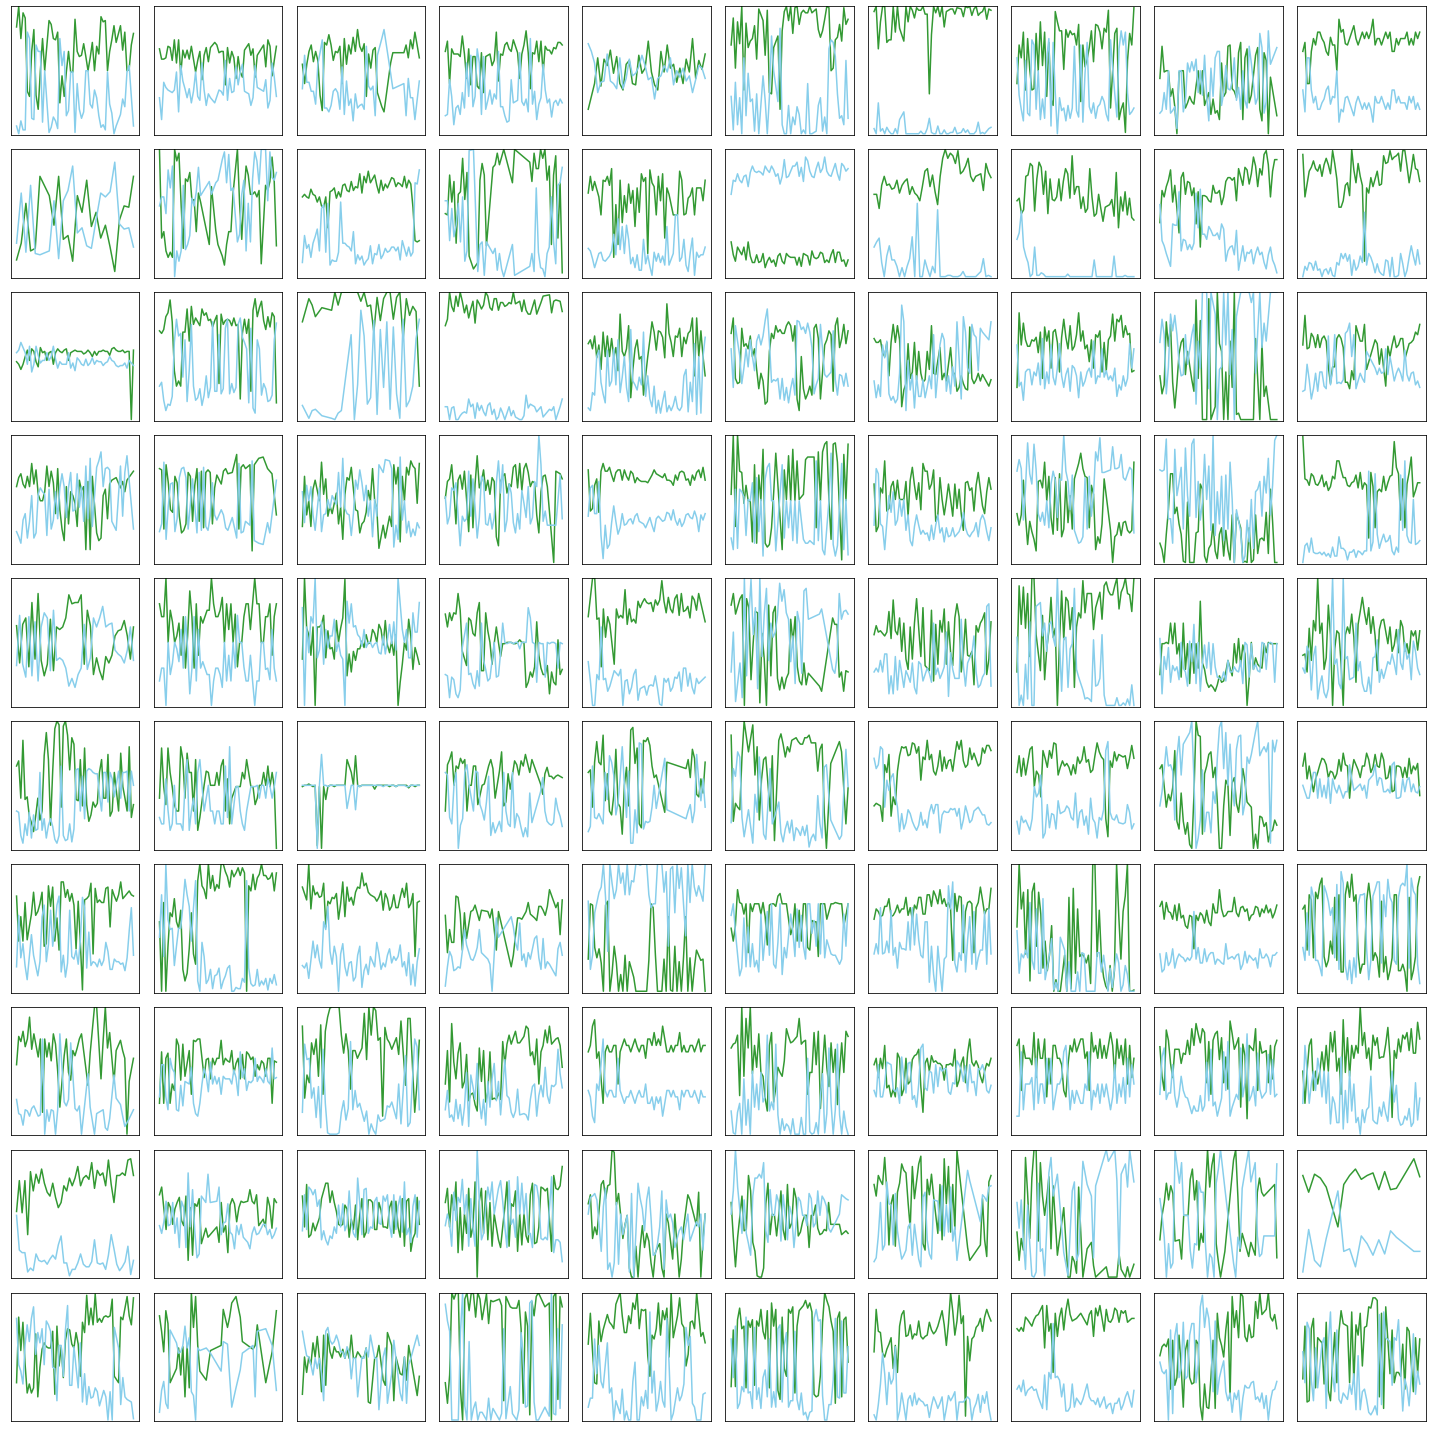

In [4]:
plt.rcParams["figure.figsize"] = [20, 20]

skip = [3]
offset = 0
for i in range(100 + len(skip)):
    if i + offset in skip:
        offset += 1
    else:
        plt.subplot(10,10,i + 1 - offset)
        plt.plot(nans_to_lines(M[i + offset]), c="green", alpha=0.8)
        plt.plot(nans_to_lines(nM[i + offset]), c="skyblue")
        #plt.ylabel("Positive Mood Effect")
        #plt.xlabel("Day")
        plt.ylim(0, 100)
        plt.xticks([],[])
        plt.yticks([], [])
        #plt.title("Positive mood by day")
plt.tight_layout()


# Histogram of Mood Affect

The most frequent ranges of the two moods were near 75 for positive and near 25 for negative,

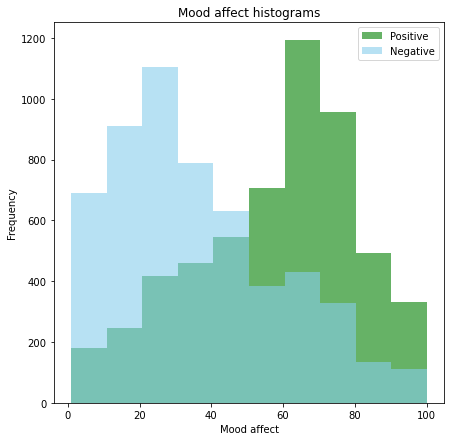

In [5]:
plt.rcParams["figure.figsize"] = [7,7]
plt.hist(np.ravel(M), bins=10, color="green", alpha=0.6, label="Positive")
plt.hist(np.ravel(nM), bins=10, color="skyblue", alpha=.6, label="Negative")
plt.legend()
plt.ylabel("Frequency")
plt.xlabel("Mood affect")
plt.title("Mood affect histograms")
plt.show()

# Fourier Transform
### Take the fourier transform of each mood, then average

74


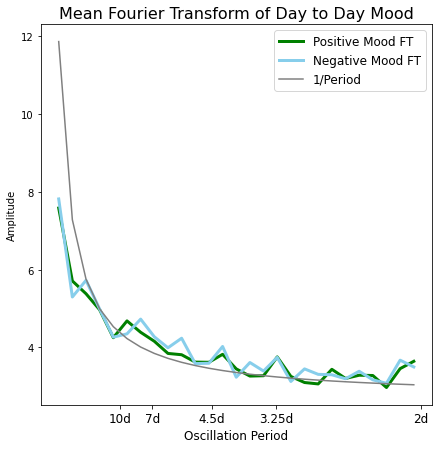

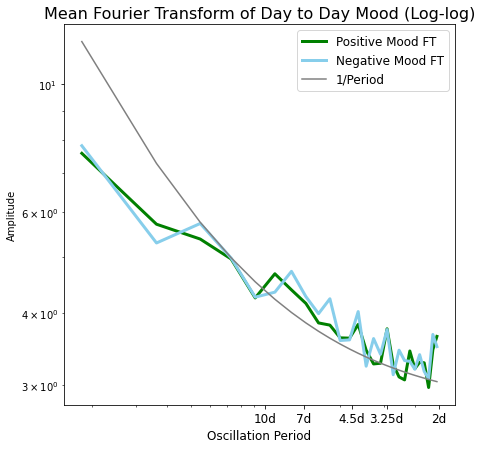

In [6]:
Xf = []
Yf = []
for i in range(M.shape[0]):
    yc = nans_to_lines(M[i])
    t = np.arange(0, len(yc))
    xf, yf = fourier_transform(t, yc)
    Xf.append(xf)
    Yf.append(yf)

siglen = np.array([l for l in map(len, Xf)])
inds = np.where(siglen == 28)[0]
muf = np.zeros(28)
k = len(inds)
for i in inds:
    muf += Yf[i]
muf /= k

nXf = []
nYf = []
for i in range(nM.shape[0]):
    yc = nans_to_lines(nM[i])
    t = np.arange(0, len(yc))
    xf, yf = fourier_transform(t, yc)
    nXf.append(xf)
    nYf.append(yf)

siglen = np.array([l for l in map(len, nXf)])
inds = np.where(siglen == 28)[0]
neg_muf = np.zeros(28)
k = len(inds)
for i in inds:
    neg_muf += nYf[i]
neg_muf /= k
print(k)

plt.rcParams["figure.figsize"] = [7, 7]
# 1/f scale
plt.plot(Xf[i][1:], muf[1:], c="green", lw=3, label="Positive Mood FT")
plt.plot(nXf[i][1:], neg_muf[1:], c="skyblue", lw=3, label="Negative Mood FT")
plt.plot(Xf[i][1:], 1/(6*Xf[i][1:]) + 2.7, c="gray", label="1/Period")

plt.legend(fontsize=12)
plt.title("Mean Fourier Transform of Day to Day Mood", fontsize=16)
plt.ylabel("Amplitude")
plt.xlabel("Oscillation Period", fontsize=12)
plt.xticks([1/10, 1/7, 1/4.5, 1/3.25, 1/2], ["10d", "7d", "4.5d", "3.25d", "2d" ], fontsize=12)
plt.show()

## Log log plot
plt.loglog(Xf[i][1:], muf[1:], c="green", lw=3, label="Positive Mood FT")
plt.loglog(nXf[i][1:], neg_muf[1:], c="skyblue", lw=3, label="Negative Mood FT")

# Underlying distribution
plt.loglog(Xf[i][1:], 1/(6*Xf[i][1:]) + 2.7, c="gray", label="1/Period")

plt.legend(fontsize=12)
plt.title("Mean Fourier Transform of Day to Day Mood (Log-log)", fontsize=16)
plt.ylabel("Amplitude")
plt.xlabel("Oscillation Period", fontsize=12)
plt.xticks([1/10, 1/7, 1/4.5, 1/3.25, 1/2], ["10d", "7d", "4.5d", "3.25d", "2d" ], fontsize=12)
plt.show()

In neuronal networks, there is an assumed underlying 1/f distribution of frequencies. Places where the spectrum departs from this underlying distribution are highlighted as "peaks" and appear or disapear based on activity. Interestingly, there appears to be an underlying 1/f distribution in mood spectrum. There also appear to be standard frequency peaks that appear in both positive and negative mood.

# Autocorrelation

### Take the autocorrelation of each mood, then average over all data points

74
74


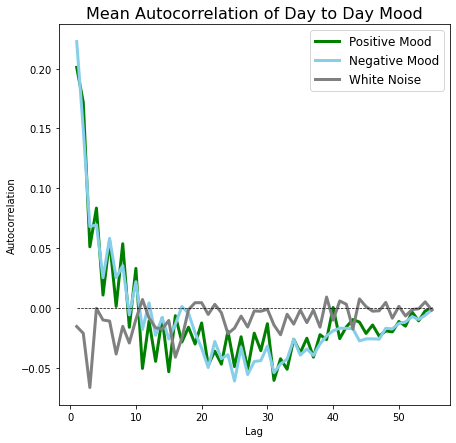

In [7]:
# Compute autocorrelation of each mood signal
Ac = []
negAc = []
for mi, nmi in zip(M, nM):
    Ac.append(autocorr(nans_to_lines(mi)))
    negAc.append(autocorr(nans_to_lines(nmi)))

# Mean positive mood autocorrelation
siglen = np.array([l for l in map(len, Ac)])
inds = np.where(siglen == 56)[0]
mu_ac = np.zeros(56)
k = len(inds)
for i in inds:
    mu_ac += Ac[i]
mu_ac /= k
print(k)

# Mean positive mood autocorrelation
siglen = np.array([l for l in map(len, negAc)])
inds = np.where(siglen == 56)[0]
neg_mu_ac = np.zeros(56)
k = len(inds)
for i in inds:
    neg_mu_ac += negAc[i]
neg_mu_ac /= k
print(k)

lag = np.arange(1, 56)

white_mean_ac = np.mean([autocorr(np.random.rand(56)) for i in range(50)], axis=0)


plt.rcParams["figure.figsize"] = [7, 7]
plt.plot(lag, mu_ac[1:], c="green", label="Positive Mood", lw=3)
plt.plot(lag, neg_mu_ac[1:], c="skyblue", label="Negative Mood", lw=3)
plt.plot(lag, white_mean_ac[1:], c="gray", label="White Noise", lw=3)
plt.plot(lag, np.zeros_like(lag), "--", c="k", lw=0.7)
plt.legend(fontsize=12)
plt.title("Mean Autocorrelation of Day to Day Mood", fontsize=16)
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.show()

This looks similar to local field potential in the brain, see [here](http://www.scholarpedia.org/article/Local_field_potential).  Open question: What does the 1/f fourier curve look like in the time domain.